# Demonstrating Provenance for netcdf/xarray workflows.


Authors: Alessandro Spinuso and Andrej Mihajlovski, 
Royal Netherlands Meteorologic Institure (KNMI)


The following demonstration focuses on presenting provenance using PROV-S and W3C for a simple workflow using dataset input and output elements.

The dispel4py framework is utalised for the workflows. 
Xarray for inmemory management of netcdf/opendap data.
Matplotlib for visualisation.
W3C for provenance representation.

In [1]:
import xarray
#import netCDF4
import json

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from collections import OrderedDict
import time
import random

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

import matplotlib.pyplot as plt
import traceback

from pprint import pprint

Simple Workflow, xarray in xarray out. 
The generic processing elements are defined bellow. GenericPE bellongs to the dispel4py framework. It allows pickeled elements to be passed as inputs and outputs. The elements are linked and visualised via the workflow_graph component.
The three components defined bellow:
- Read, xarray is read into memory.
- Workflow, xarray is processed/passed to output (no changes)
- Write, xarray is visualised.

SETTING NAME: Read
SETTING NAME: Workflow
SETTING NAME: Write


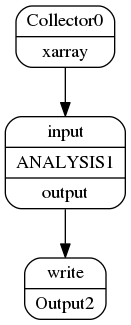

In [2]:
class Read(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('xarray')

    def _process(self,inputs):
        self.log('Read_Process')
     
        self.log(inputs)
        
        inputLocation = inputs['input'][0]

        ds = xarray.open_dataset( inputLocation )
    
        self.write( 'xarray' , (ds , inputs['input'][1]) , location=inputLocation )

            
class Write(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('write')
        self._add_output('end')
        
    def _process(self,inputs):
        self.log('Write_Function')
        
        outputLocation = inputs['write'][1]
        
        inputs['write'][0].to_netcdf( outputLocation )
                
        self.write('end', inputs['write'],location=outputLocation )
        
        
class Workflow(GenericPE):
        
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
    def _process(self,inputs):
        self.log('Workflow_process')
        
        #self.log(inputs)
        
        #nc = inputs['input'][0]
        nc = inputs['input'][0]
        #self.log(nc)
        #
        self.write('output', (nc , inputs['input'][1] ))


readX  = Read()
readX.name = 'Collector'

wf     = Workflow()
wf.name    = 'ANALYSIS'
wf.parameters = { 'wf':'param' }

writeX = Write()
writeX.name = 'Output'


#Initialise the graph
def createWorkflowGraph():
    graph = WorkflowGraph()    
    graph.connect(readX ,'xarray'   , wf     ,'input')
    graph.connect(wf    ,'output'   , writeX , 'write')

    return graph

graph = createWorkflowGraph()


from dispel4py.visualisation import display
display(graph)


def runExampleWorkflow():
    #infile = 'input_simple.json'
    #with open(infile) as data_file:    
    #    input_data = json.load(data_file)
    
    #print infile                                                     
    print input_data                   

    #Launch in simple process
    simple_process.process_and_return(graph, input_data)

Input specified.

In [3]:
input_data = { 
                # 'Collector': [ { 'input': [ 'data/newA.nc', 'data/newOut.nc']} ] 
                'Collector': [ { 'input': [ 'data/newA.nc', 'data/newOut.nc']} , { 'input': [ 'data/newA.nc', 'data/newB.nc']} , { 'input': [ 'data/newA.nc', 'data/newC.nc'] }  ]
                #'Collector': [ { 'input': [ 'data/newOut.nc', 'data/newB.nc']}]
                #'Collector': [ { 'input': [ 'data/newB.nc', 'data/newC.nc']}]
    
                #'Collector': [ { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc',
                #                 'data/opendapOutput.nc']}]
    
                #'Collector': [ { 'input' : [ 'data/opendapOutput.nc','data/opendapEnd.nc']}]
             }



In [4]:
runExampleWorkflow()

{'Collector': [{'input': ['data/newA.nc', 'data/newOut.nc']}, {'input': ['data/newA.nc', 'data/newB.nc']}, {'input': ['data/newA.nc', 'data/newC.nc']}]}
SETTING NAME: SimpleProcessingPE
Collector0: Read_Process
Collector0: {'input': ['data/newA.nc', 'data/newOut.nc']}
Collector0: Read_Process
Collector0: {'input': ['data/newA.nc', 'data/newB.nc']}
Collector0: Read_Process
Collector0: {'input': ['data/newA.nc', 'data/newC.nc']}
ANALYSIS1: Workflow_process
ANALYSIS1: Workflow_process
ANALYSIS1: Workflow_process
Output2: Write_Function
Output2: Write_Function
Output2: Write_Function
SimplePE: Processed 1 iteration.


Definition of a Provenance Processing Element. This element will be run in parallel to other process, it is defined to extract provenance information from a netCDF/xarray.

In [5]:
class netcdfProvType(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
    
    def extractExternalInputDataId(self,data, input_port):
        #Extract here the id from the data (type specific):

        self.log('ANDREJ.extractExternalInputDataId')
        #self.log(data)
        
        try:
            #ds = xarray.open_dataset(data['input'][0])
            ds = xarray.open_dataset(data[0])
            id = ds.attrs['id']
            
        except Exception, err:
            id = str(uuid.uuid1())
            self.log(str(err))
        #Return
        return id
    
    
    def makeUniqueId(self, data, output_port):      
        
        self.log('ANDREJ.makeUniqueId')
        #self.log(kwargs)
        
        #produce the id
        id=str(uuid.uuid1())
            
        ''' nc data '''
        xa = data[0]
        
        ''' unique as defined by the community standard '''
        xa.attrs['id'] = id
        
        #Return
        return id 
    

    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self,data, output_port):
        
        self.log('ANDREJ.extractItemMetadata')
        #self.log(data)
        
        try:            
            nc_meta = OrderedDict()
            
            ''' cycle throug all attributes, dimensions and variables '''
            xa = data[0]
                        
            # dataset meta
            nc_meta['Dimensions'] = str( dict(xa.dims)) 
            nc_meta['Type'] = str(type(xa))
            
            # global attr
            for k , v in xa.attrs.items():
                nc_meta[str(k).replace(".","_")] = str(v)
            # vars attr   
            for n , i in xa.data_vars.items():
                for k , v in i.attrs.items():
                    nc_meta[n+"_"+str(k).replace(".","_")] = str(v)
            
            #pprint(nc_meta)
        
            metadata = [nc_meta]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data);
        

A high level 'template/profile' describing the provenance process.

In [6]:
prov_profile =  {
                    'username': "andrej", 
                    'w3c_prov': False   ,
                    'description' : "provdemo basic",
                    'workflowName': "demo_ecmwf"      ,
                    'workflowId'  : "workflow process",
                    'save_mode'   : 'service'         ,
    
                 # defines the use of the ProvenancePE with the Workflow element
                    #'componentsType' : {'Workflow':(netcdfProvType,) , 'Collector':(netcdfProvType,),'Write':(netcdfProvType,)}
                    'componentsType' : {'Workflow':(netcdfProvType,) , 'Collector':(netcdfProvType,) } 
}

The REPOS_URL is the target provenence depo. Used as a production tool for VERCE (Seismo), CLIPC (C3S) and Climate4Impact (Climate IS-ENES)

In [7]:
#Store via service
#ProvenancePE.REPOS_URL='http://127.0.0.1:8080/j2ep-1.0/prov/workflow/insert'
#ProvenancePE.REPOS_URL='http://portal.verce.eu/j2ep-1.0/prov/workflow/insert'
ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'

#Export data lineage via service (REST GET Call on dataid resource)
ProvenancePE.PROV_EXPORT_URL="http://climate4impact.eu/prov/workflow/export/data/" 


#Store to local path
ProvenancePE.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenancePE.BULK_SIZE=20

#ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'


{'username': 'andrej', 'w3c_prov': False, 'workflowId': 'workflow process', 'description': 'provdemo basic', 'save_mode': 'service', 'workflowName': 'demo_ecmwf', 'componentsType': {'Collector': (<class '__main__.netcdfProvType'>,), 'Workflow': (<class '__main__.netcdfProvType'>,)}}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: ANALYSIS Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting provenance to: ANALYSIS Transoformed: (<class 'dispel4py.provenance.ProvenancePE'>, <class '__main__.Workflow'>)
Change grouping implementation 
Injecting provenance to: Collector Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: netcdfProvType
Injecting provenance to: Collector Transoformed: (<class '__main__.netcdfProvType'>, <class '__main__.Read'>)
Change grouping implementation 
Injecting provenance to: Output Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: ProvenancePE
Injecting pr

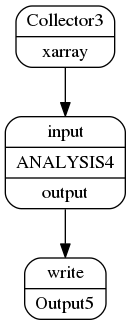

In [8]:
def createGraphWithProv():
    
    graph=createWorkflowGraph()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_SIMPLE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    print prov_profile

    ##Initialise provenance storage in files:
    #profile_prov_run(graph,None,provImpClass=(ProvenancePE,),componentsType={'CorrCoef':(ProvenancePE,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='file')
                  # skip_rules={'CorrCoef':{'ro':{'$lt':0}}})

    #Initialise provenance storage to service:
    profile_prov_run(graph, 
                     None,
                     provImpClass=(ProvenancePE,),
                     username=prov_profile['username'],
                     runId=rid,
                     w3c_prov=prov_profile['w3c_prov'],
                     description=prov_profile['description'],
                     workflowName=prov_profile['workflowName'],
                     workflowId=prov_profile['workflowId'],
                     save_mode=prov_profile['save_mode'],
                     componentsType=prov_profile['componentsType']
                    )
                   #skip_rules={'CorrCoef':{'ro':{'$lt':0}}})

    #clustersRecorders={'record0':ProvenanceRecorderToFileBulk,'record1':ProvenanceRecorderToFileBulk,'record2':ProvenanceRecorderToFileBulk,'record6':ProvenanceRecorderToFileBulk,'record3':ProvenanceRecorderToFileBulk,'record4':ProvenanceRecorderToFileBulk,'record5':ProvenanceRecorderToFileBulk}
    #Initialise provenance storage to sensors and Files:
    #profile_prov_run(graph,ProvenanceRecorderToFile,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
    #clustersRecorders=clustersRecorders)
    
    #Initialise provenance storage to sensors and service:
    #profile_prov_run(graph,ProvenanceRecorderToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
    #Summary view on each component
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor')
   
   
   
    #Configuring provenance feedback-loop
    #profile_prov_run(graph,ProvenanceTimedSensorToService,provImpClass=(ProvenancePE,),username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='sensor',feedbackPEs=['Source','MaxClique'])
   
   
    #Initialise provenance storage end associate a Provenance type with specific components:
    #profile_prov_run(graph,provImpClass=ProvenancePE,componentsType={'Source':(ProvenanceStock,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='service')

    #
    return graph


graph=createGraphWithProv()

display(graph)

The workflow is rerun with provenace enabled.

In [9]:
runExampleWorkflow()

{'Collector': [{'input': ['data/newA.nc', 'data/newOut.nc']}, {'input': ['data/newA.nc', 'data/newB.nc']}, {'input': ['data/newA.nc', 'data/newC.nc']}]}
SETTING NAME: SimpleProcessingPE
Collector3: ANDREJ.extractExternalInputDataId
Collector3: 'id'
Collector3: BUILDING INITIAL DERIVATION
Collector3: Read_Process
Collector3: {'input': ['data/newA.nc', 'data/newOut.nc']}
Collector3: ANDREJ.extractItemMetadata
Collector3: ANDREJ.makeUniqueId
Collector3: ANDREJ.extractExternalInputDataId
Collector3: 'id'
Collector3: BUILDING INITIAL DERIVATION
Collector3: Read_Process
Collector3: {'input': ['data/newA.nc', 'data/newB.nc']}
Collector3: ANDREJ.extractItemMetadata
Collector3: ANDREJ.makeUniqueId
Collector3: ANDREJ.extractExternalInputDataId
Collector3: 'id'
Collector3: BUILDING INITIAL DERIVATION
Collector3: Read_Process
Collector3: {'input': ['data/newA.nc', 'data/newC.nc']}
Collector3: ANDREJ.extractItemMetadata
Collector3: ANDREJ.makeUniqueId
ANALYSIS4: Workflow_process
ANALYSIS4: Workflow

The following link requires a local tomcat server to proxy to the provenance depo.


http://localhost:8180/provenance-explorer/html/view.jsp

The End

In [10]:
# output location.
finalFile = input_data['Collector'][0]['input'][1]
print finalFile

data/newOut.nc


Visualis Output

!ncview data/newOut.nc

In [11]:
''' read id of output to locate prov '''
ds = xarray.open_dataset( finalFile )
dataid = ds.attrs['id']     #"orfeus-as-73355-c381c282-d422-11e6-ac42-f45c89acf865"

'''
https://github.com/aspinuso/dispel4py/blob/master/d4py-prov-xcorrelation-example.ipynb
'''
print("Extract Trace for dataid: "+dataid)
expurl = urlparse(ProvenancePE.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
print(expurl.netloc+expurl.path+dataid+"?all=true")
connection.request(
                "GET", expurl.path+dataid+"?all=true")
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
prov1 = response.read()
print('PROV TO EMBED:')

Extract Trace for dataid: 723fa04c-d8a5-11e6-b96a-901b0e877023
climate4impact.eu/prov/workflow/export/data/723fa04c-d8a5-11e6-b96a-901b0e877023?all=true
progress: (200, '')
PROV TO EMBED:


In [12]:
print str(prov1)

<?xml version='1.0' encoding='ASCII'?>
<prov:document xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:s-prov="http://s-prov">
  <prov:agent prov:id="s-prov:andrej">
    <dcterms:author>andrej</dcterms:author>
  </prov:agent>
  <prov:bundle prov:id="s-prov:JUP_SIMPLE_pc150396.knmi.nl-22012-71a682d6-d8a5-11e6-b96a-901b0e877023">
    <s-prov:_id>JUP_SIMPLE_pc150396.knmi.nl-22012-71a682d6-d8a5-11e6-b96a-901b0e877023</s-prov:_id>
    <s-prov:description>provdemo basic</s-prov:description>
    <s-prov:mapping>-f</s-prov:mapping>
    <s-prov:modules>[u'apache-libcloud==1.0.0', u'argh==0.23.2', u'astroid==1.3.6', u'autosubmit==3.6.1', u'babel==1.3', u'backports-abc==0.5', u'backports.shutil-get-terminal-size==1.0.0', u'backports.ssl-match-hostname==3.5.0.1', u'basemap==1.0.7', u'beaker==1.5.4', u'beautifulsoup4==4.5.1', u'beautifulsoup==3.2.1', u'bleach==1.

In [13]:
#ds. create variable save to file

ds['provenance'] = xarray.DataArray({ 'prov_xml': str(prov1)})

#ds.close()

print ds

#ds.to_netcdf( str("0"+finalFile) )


<xarray.Dataset>
Dimensions:     (time: 1, x: 424, y: 412)
Coordinates:
  * x           (x) float64 -44.62 -44.36 -44.1 -43.84 -43.58 -43.32 -43.06 ...
  * y           (y) float64 21.98 22.1 22.23 22.35 22.47 22.59 22.72 22.84 ...
  * time        (time) datetime64[ns] 2099-01-16
Data variables:
    vDTR        (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    crs         |S1 ''
    provenance  object {'prov_xml': '<?xml version=\'1.0\' encoding=\'ASCII\'?>\n<prov:document xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:s-prov="http://s-prov">\n  <prov:agent prov:id="s-prov:andrej">\n    <dcterms:author>andrej</dcterms:author>\n  </prov:agent>\n  <prov:bundle prov:id="s-prov:JUP_SIMPLE_pc150396.knmi.nl-22012-71a682d6-d8a5-11e6-b96a-901b0e877023">\n    <s-prov:_id>JUP_SIMPLE_pc150396.knmi.nl-22012-71a682d6-d8a5-11e6-b96a-901b0e87702

In [14]:
import prov
import io
import StringIO
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provToSvg(xml,output_f):
     
    xml_doc = StringIO.StringIO()
    xml_doc.write(str(xml))
    xml_doc.seek(0, 0)
    #print xml_doc
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    return dot.create(format=output_f)
    

#prov_doc=open(prov).read()

#print prov1

svg_content=provToSvg(prov1,"svg")

with open("PROV.svg","w+") as text_file:
    text_file.write(str(svg_content))


from IPython.core.display import display, HTML
display(HTML(str(svg_content)))

    
# visualse NetCDF provenance in SVG

An example of the above W3C prov xml can be viewed using:

https://provenance.ecs.soton.ac.uk/store/

https://provenance.ecs.soton.ac.uk/store/documents/115540.svg


the end.